In [18]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [19]:
CSV_BASE_PATH = r"C:\Users\user\Desktop\olist\csv"

file_paths = {
    "customers": os.path.join(CSV_BASE_PATH, "olist_customers_dataset.csv"),
    "orders": os.path.join(CSV_BASE_PATH, "olist_orders_dataset.csv"),
    "order_items": os.path.join(CSV_BASE_PATH, "olist_order_items_dataset.csv"),
    "reviews": os.path.join(CSV_BASE_PATH, "olist_order_reviews_dataset.csv"),
    "payments": os.path.join(CSV_BASE_PATH, "olist_order_payments_dataset.csv"),
    "products": os.path.join(CSV_BASE_PATH, "olist_products_dataset.csv"),
    "categories": os.path.join(CSV_BASE_PATH, "product_category_name_translation.csv"),
    "geolocation": os.path.join(CSV_BASE_PATH, "olist_geolocation_dataset.csv"),
}

customers   = pd.read_csv(file_paths["customers"])
orders     = pd.read_csv(file_paths["orders"])
order_items = pd.read_csv(file_paths["order_items"])
reviews     = pd.read_csv(file_paths["reviews"])
payments    = pd.read_csv(file_paths["payments"])
products    = pd.read_csv(file_paths["products"])
categories  = pd.read_csv(file_paths["categories"])
geolocation = pd.read_csv(file_paths["geolocation"])

print("Loaded shapes:",
      customers.shape, orders.shape, order_items.shape, reviews.shape,
      payments.shape, products.shape, categories.shape, geolocation.shape)

Loaded shapes: (99441, 5) (99441, 8) (112650, 7) (99224, 7) (103886, 5) (32951, 9) (71, 2) (1000163, 5)


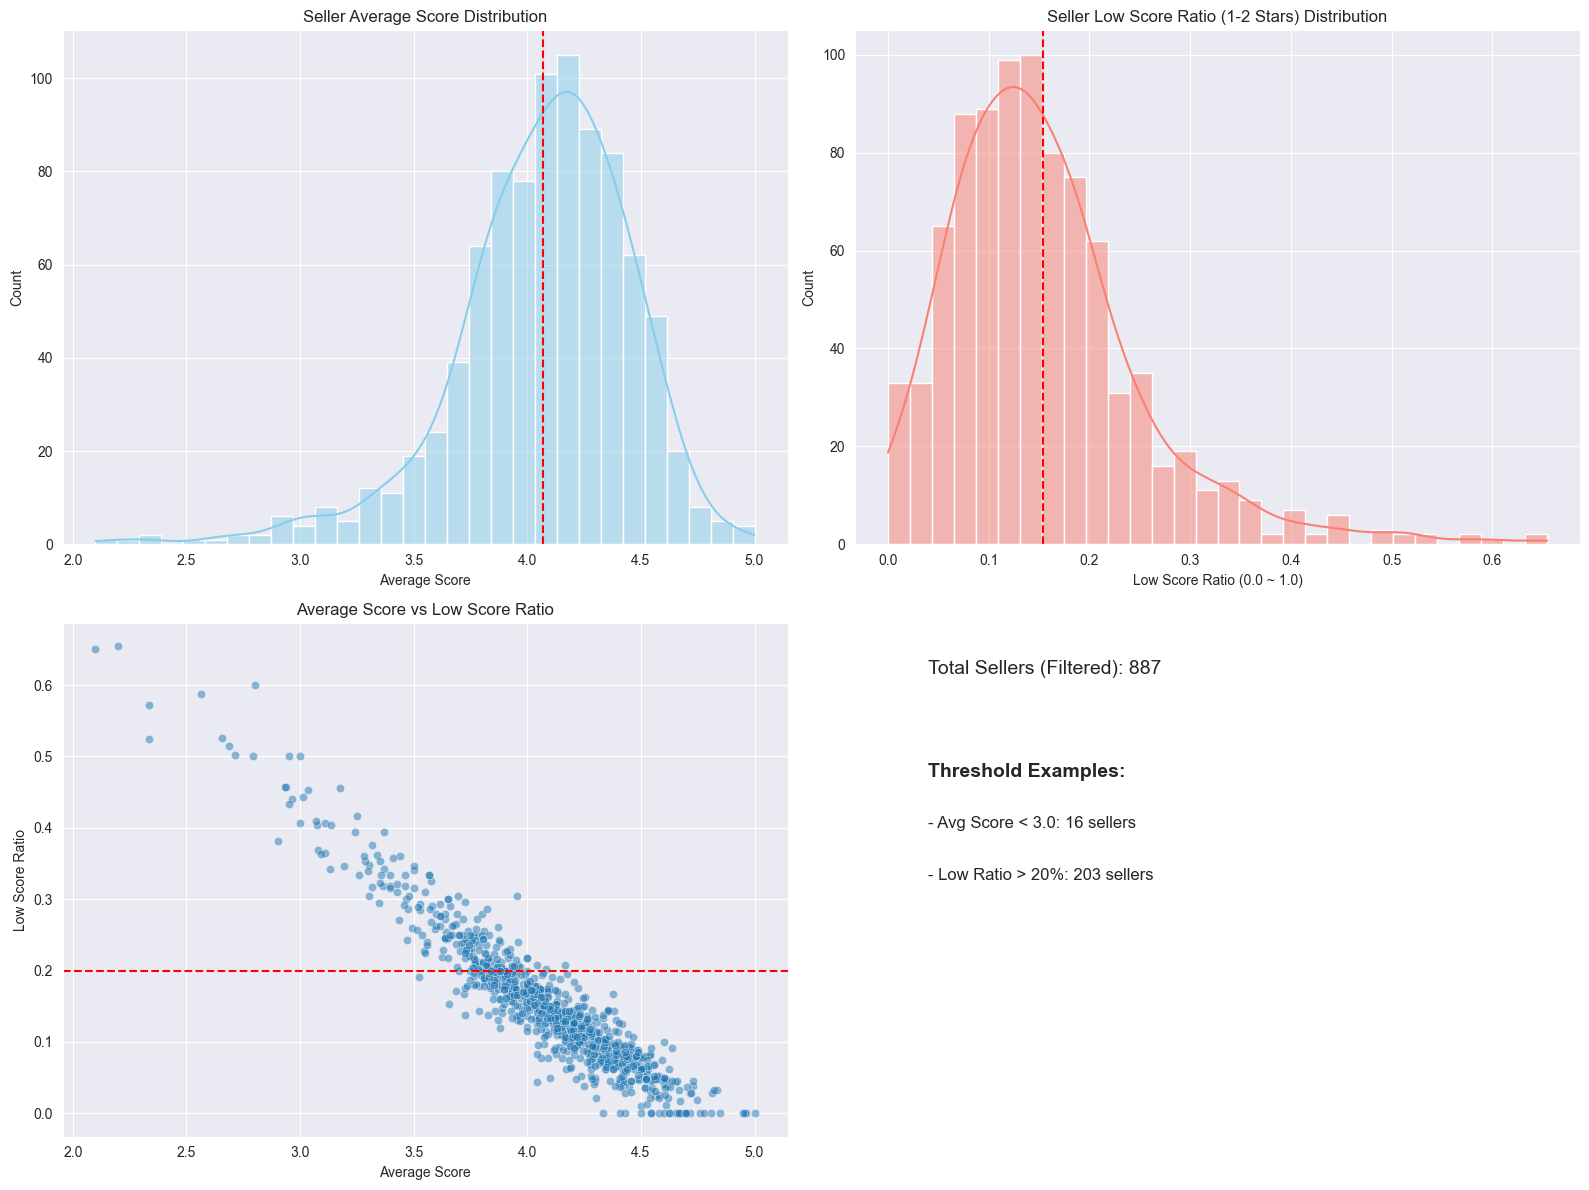

In [28]:
seller_reviews = pd.merge(order_items[['order_id', 'seller_id']],
                          reviews[['order_id', 'review_score']],
                          on='order_id',
                          how='inner')

seller_stats = seller_reviews.groupby('seller_id').agg(
    review_count=('review_score', 'count'),
    avg_score=('review_score', 'mean'),
    low_score_ratio=('review_score', lambda x: (x <= 2).mean())
).reset_index()

seller_stats_filtered = seller_stats[seller_stats['review_count'] >= 20]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(seller_stats_filtered['avg_score'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Seller Average Score Distribution')
axes[0, 0].set_xlabel('Average Score')
axes[0, 0].axvline(seller_stats_filtered['avg_score'].mean(), color='red', linestyle='--', label='Mean')

sns.histplot(seller_stats_filtered['low_score_ratio'], bins=30, kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Seller Low Score Ratio (1-2 Stars) Distribution')
axes[0, 1].set_xlabel('Low Score Ratio (0.0 ~ 1.0)')
axes[0, 1].axvline(seller_stats_filtered['low_score_ratio'].mean(), color='red', linestyle='--', label='Mean')

sns.scatterplot(data=seller_stats_filtered, x='avg_score', y='low_score_ratio', alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Average Score vs Low Score Ratio')
axes[1, 0].set_xlabel('Average Score')
axes[1, 0].set_ylabel('Low Score Ratio')
axes[1, 0].axhline(0.2, color='red', linestyle='--', label='20% Threshold')

axes[1, 1].axis('off')
axes[1, 1].text(0.1, 0.9, f"Total Sellers (Filtered): {len(seller_stats_filtered)}", fontsize=14)
axes[1, 1].text(0.1, 0.7, "Threshold Examples:", fontsize=14, fontweight='bold')
axes[1, 1].text(0.1, 0.6, f"- Avg Score < 3.0: {len(seller_stats_filtered[seller_stats_filtered['avg_score'] < 3.0])} sellers", fontsize=12)
axes[1, 1].text(0.1, 0.5, f"- Low Ratio > 20%: {len(seller_stats_filtered[seller_stats_filtered['low_score_ratio'] > 0.2])} sellers", fontsize=12)

plt.tight_layout()
plt.show()


In [36]:
top_bad_sellers = seller_stats_filtered.sort_values('low_score_ratio', ascending=False).head(5)
top_bad_seller_ids = top_bad_sellers['seller_id'].tolist()

print("저평점 비율 상위 5명 셀러 정보")
print(top_bad_sellers[['seller_id', 'avg_score', 'low_score_ratio', 'review_count']])

if 'order_approved_at' in orders.columns:
    orders_dates = orders[['order_id', 'order_approved_at', 'order_delivered_carrier_date']].copy()
    orders_dates['order_approved_at'] = pd.to_datetime(orders_dates['order_approved_at'])
    orders_dates['order_delivered_carrier_date'] = pd.to_datetime(orders_dates['order_delivered_carrier_date'])

    bad_seller_items = order_items[order_items['seller_id'].isin(top_bad_seller_ids)][['order_id', 'seller_id', 'shipping_limit_date']]
    bad_seller_items['shipping_limit_date'] = pd.to_datetime(bad_seller_items['shipping_limit_date'])

    bad_seller_analysis = pd.merge(bad_seller_items, orders_dates, on='order_id', how='inner')

    bad_seller_analysis['prep_days'] = (bad_seller_analysis['order_delivered_carrier_date'] - bad_seller_analysis['order_approved_at']).dt.total_seconds() / (24 * 3600)

    seller_prep_stats = bad_seller_analysis.groupby('seller_id').agg(
        avg_prep_days=('prep_days', 'mean')).reset_index()

    print("\n상위 5명 셀러의 준비 시간 상세")
    print(seller_prep_stats)

저평점 비율 상위 5명 셀러 정보
                             seller_id  avg_score  low_score_ratio  \
333   1ca7077d890b907f89be8c954a02686a   2.198529         0.654412   
3089  ffff564a4f9085cd26170f4732393726   2.100000         0.650000   
2722  e250d617a0ad591ba9bd663e584a895d   2.800000         0.600000   
463   2709af9587499e95e803a6498a5a56e9   2.565217         0.586957   
1126  5bc55dbe2f12b6af6d83ed46023e0dc8   2.333333         0.571429   

      review_count  
333            136  
3089            20  
2722            20  
463             46  
1126            21  

상위 5명 셀러의 준비 시간 상세
                          seller_id  avg_prep_days
0  1ca7077d890b907f89be8c954a02686a       5.238980
1  2709af9587499e95e803a6498a5a56e9       2.330683
2  5bc55dbe2f12b6af6d83ed46023e0dc8       3.318350
3  e250d617a0ad591ba9bd663e584a895d       1.255236
4  ffff564a4f9085cd26170f4732393726       7.017610


In [33]:
top_seller_items = order_items[order_items['seller_id'] == target_seller_id]
top_seller_products = pd.merge(top_seller_items, products[['product_id', 'product_category_name']], on='product_id')
main_category = top_seller_products['product_category_name'].mode()[0]

category_items = pd.merge(order_items[['order_id', 'product_id']], products[['product_id', 'product_category_name']], on='product_id')
category_orders = category_items[category_items['product_category_name'] == main_category]['order_id']
category_reviews = reviews[reviews['order_id'].isin(category_orders)]

category_avg_score = category_reviews['review_score'].mean()
seller_avg_score = target_reviews['review_score'].mean()

category_p20_score = category_reviews['review_score'].quantile(0.2)
seller_p20_score = target_reviews['review_score'].quantile(0.2)

print(f"해당 카테고리 전체 평균 평점: {category_avg_score:.2f}")
print(f"이 셀러의 평균 평점: {seller_avg_score:.2f}")

print(f"\n해당 카테고리 전체 하위 20% 점수(P20): {category_p20_score:.1f}")
print(f"이 셀러의 하위 20% 점수(P20): {seller_p20_score:.1f}")


해당 카테고리 전체 평균 평점: 4.00
이 셀러의 평균 평점: 2.20

해당 카테고리 전체 하위 20% 점수(P20): 3.0
이 셀러의 하위 20% 점수(P20): 1.0
